In [20]:
# 학습에 필요한 라이브러리를 불러옵니다
import os
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
from PIL import Image
from google.colab import drive
import natsort
from sklearn.metrics import mean_squared_error 
import math

In [21]:
# 배치 크기
batch_size = 4

# 이미지의 채널 수로, GRAY 이미지이기 때문에 1 로 설정합니다
nc = 1

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 256

# 학습할 에폭 수
num_epochs = 20

# 옵티마이저의 학습률
lr_D = 0.0005         # Disciminator
lr_G = 0.001          # Generator

# Adam 옵티마이저의 beta 하이퍼파라미터
beta = (0.9,0.999)

# 학습에 사용될 장치를 선택합니다
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [22]:
# 데이터를 처리할 custom dataset
class Custom_datasets(Dataset):
    def __init__(self,img_path,gt_path,transform=None):
        self.img = img_path
        self.gt = gt_path
        self.transform = transform
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        image = Image.open(self.img[idx])
        gt = Image.open(self.gt[idx])
        if self.transform:
            image = self.transform(image)
            gt = self.transform(gt)

        else:
            return image

        return [image, gt]

In [23]:
# Google drive와 github를 연동하기 위한 코드
drive.mount('/content/drive/')                        # Google drive를 mount합니다
path = '/content/drive/MyDrive/Tutorial_1026/'        # Tutorial_1026 폴더를 만듭니다
os.makedirs(path,exist_ok=True)
os.chdir(path)
print(os.getcwd())
# github에서 데이터를 다운로드 받습니다
try:
  !git clone https://github.com/Cheque93/Tutorial_1026.git .
except:
  pass

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Tutorial_1026
fatal: destination path '.' already exists and is not an empty directory.


In [24]:
# Custom dataset을 구성합니다
# train/validation/test 셋을 설정합니다
train_path = path + 'imgs/train/'
train_noise = natsort.natsorted(np.char.add(train_path+'noise/',os.listdir(train_path+'noise')))
train_gt = natsort.natsorted(np.char.add(train_path+'gt/',os.listdir(train_path+'gt')))
print("Number of noise image for train: "+str(len(train_noise)))
print("Number of ground truth image for train: "+str(len(train_gt)))
valid_path = path + 'imgs/valid/'
valid_noise = natsort.natsorted(np.char.add(valid_path+'noise/',os.listdir(valid_path+'noise')))
valid_gt = natsort.natsorted(np.char.add(valid_path+'gt/',os.listdir(valid_path+'gt')))
print("Number of noise image for validation: "+str(len(valid_noise)))
print("Number of ground truth image for validation: "+str(len(valid_gt)))
test_path = path + 'imgs/test/'
test_noise = natsort.natsorted(np.char.add(test_path+'noise/',os.listdir(test_path+'noise')))
test_gt = natsort.natsorted(np.char.add(test_path+'gt/',os.listdir(test_path+'gt')))
print("Number of noise image for test: "+str(len(test_noise)))
print("Number of ground truth image for test: "+str(len(test_gt)))

# 데이터 transform을 설정합니다
# 현재 적용된 transform은 mean, variance 0.5로 normalize transform 입니다
data_transforms = transforms.Compose([  transforms.ToTensor(),
                                        transforms.Normalize((0.5),(0.5))
                                        ])
train_set = Custom_datasets(train_noise,train_gt,data_transforms)
valid_set = Custom_datasets(valid_noise,valid_gt,data_transforms)
test_set = Custom_datasets(test_noise,test_gt,data_transforms)
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': DataLoader(valid_set, batch_size=4, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
}

Number of noise image for train: 100
Number of ground truth image for train: 100
Number of noise image for validation: 14
Number of ground truth image for validation: 14
Number of noise image for test: 16
Number of ground truth image for test: 16


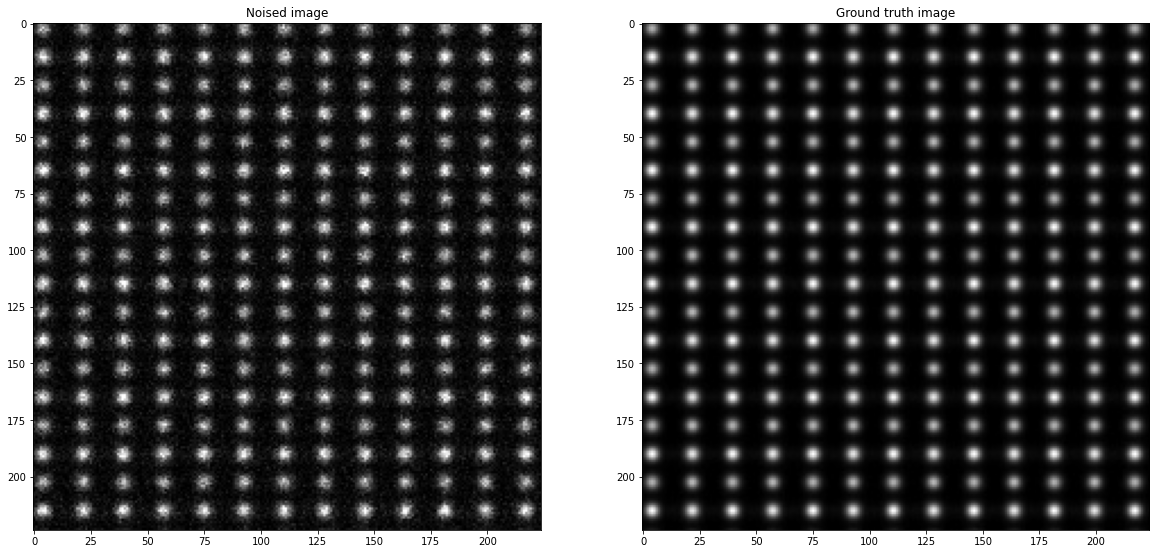

In [25]:
# dataloader 확인
tmp_dataloader = iter(dataloaders['test'])
tmp_batch = next(tmp_dataloader)
tmp_noise = tmp_batch[0].cpu().detach().numpy()[0].transpose((1,2,0))           # tensor -> numpy로 변환
tmp_gt = tmp_batch[1].cpu().detach().numpy()[0].transpose((1,2,0))
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Noised image')
ax[0].imshow(tmp_noise[:,:,0],cmap='gray')
ax[1].set_title('Ground truth image')
ax[1].imshow(tmp_gt[:,:,0],cmap='gray')


In [27]:
# Generator 모델
class Down(nn.Module):                                                                        # Encoding 부분의 Down layer
    def __init__(self, in_channels, out_channels):                                            # 2D MaxPooling과 convolution, batch normalization, PReLU로 구성됩니다
        super().__init__()                                                                    # Layer를 거치면 사이즈는 1/2로 감소하고 feature는 2배 증가합니다
        self.conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
            )

    def forward(self, x):
        return self.conv(x)
    
class Up(nn.Module):                                                                          # Decoding 부분의 Up layer
    def __init__(self, in_channels, out_channels):                                            # 2D transposed convolution과 batch normalization, PReLU로 구성됩니다
        super().__init__()                                                                    # Layer를 거치면 사이즈는 2배 증가하고 feature는 1/2로 감소합니다
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
            )
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW                    
        diffY = x2.size()[2] - x1.size()[2]                                                   # UNet의 skip-connection을 위해 padding을 통해 사이즈를 조정합니다
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UNet(nn.Module):                                                                        # 앞서 작성한 down 및 up layer를 사용한 UNet 모델
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.n_channels = n_channels                                                          # Input image의 channel
        self.inc = nn.Conv2d(n_channels, ngf,kernel_size=3, padding=1)                        # Init convolution
        self.down1 = Down(ngf, ngf*2)                                                         # Down layer를 통해 사이즈는 1/2로 감소하고 feature는 2배 증가합니다
        self.down2 = Down(ngf*2, ngf*4)
        self.up1 = Up(ngf*4, ngf*2)                                                           # Up layer를 통해 사이즈는 2배 증가하고 feature는 1/2로 감소합니다
        self.up2 = Up(ngf*2, ngf)
        self.out_conv = nn.Conv2d(ngf, n_channels, kernel_size=1)                             # channel 크기를 맞추기 위한 out convolution

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        logits =  self.out_conv(x)
        
        return logits

In [28]:
# Discriminator 모델
class Discriminator(nn.Module):
    def __init__(self,n_channels):
        super(Discriminator, self).__init__()
        self.n_channels = n_channels                                                          # Input image의 channel
        self.main = nn.Sequential(
            # input (nc) x input size x input size
            # 1 x 224 x 224
            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x (input size / 2) x (input size / 2) 
            # 256 x 112 x 112
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x (input size / 4) x (input size / 4)
            # 512 x 56 x 56
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x (input size / 8) x (input size / 8)
            # 1024 x 28 x 28
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x (input size / 16) x (input size / 16)
            # 2048 x 14 x 14
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        x = self.main(input)
        x=  F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)                           # 2d average pooling과 sigmoid를 통해 0~1의 확률값을 추출합니다
        x = nn.Sigmoid()(x)
        return x

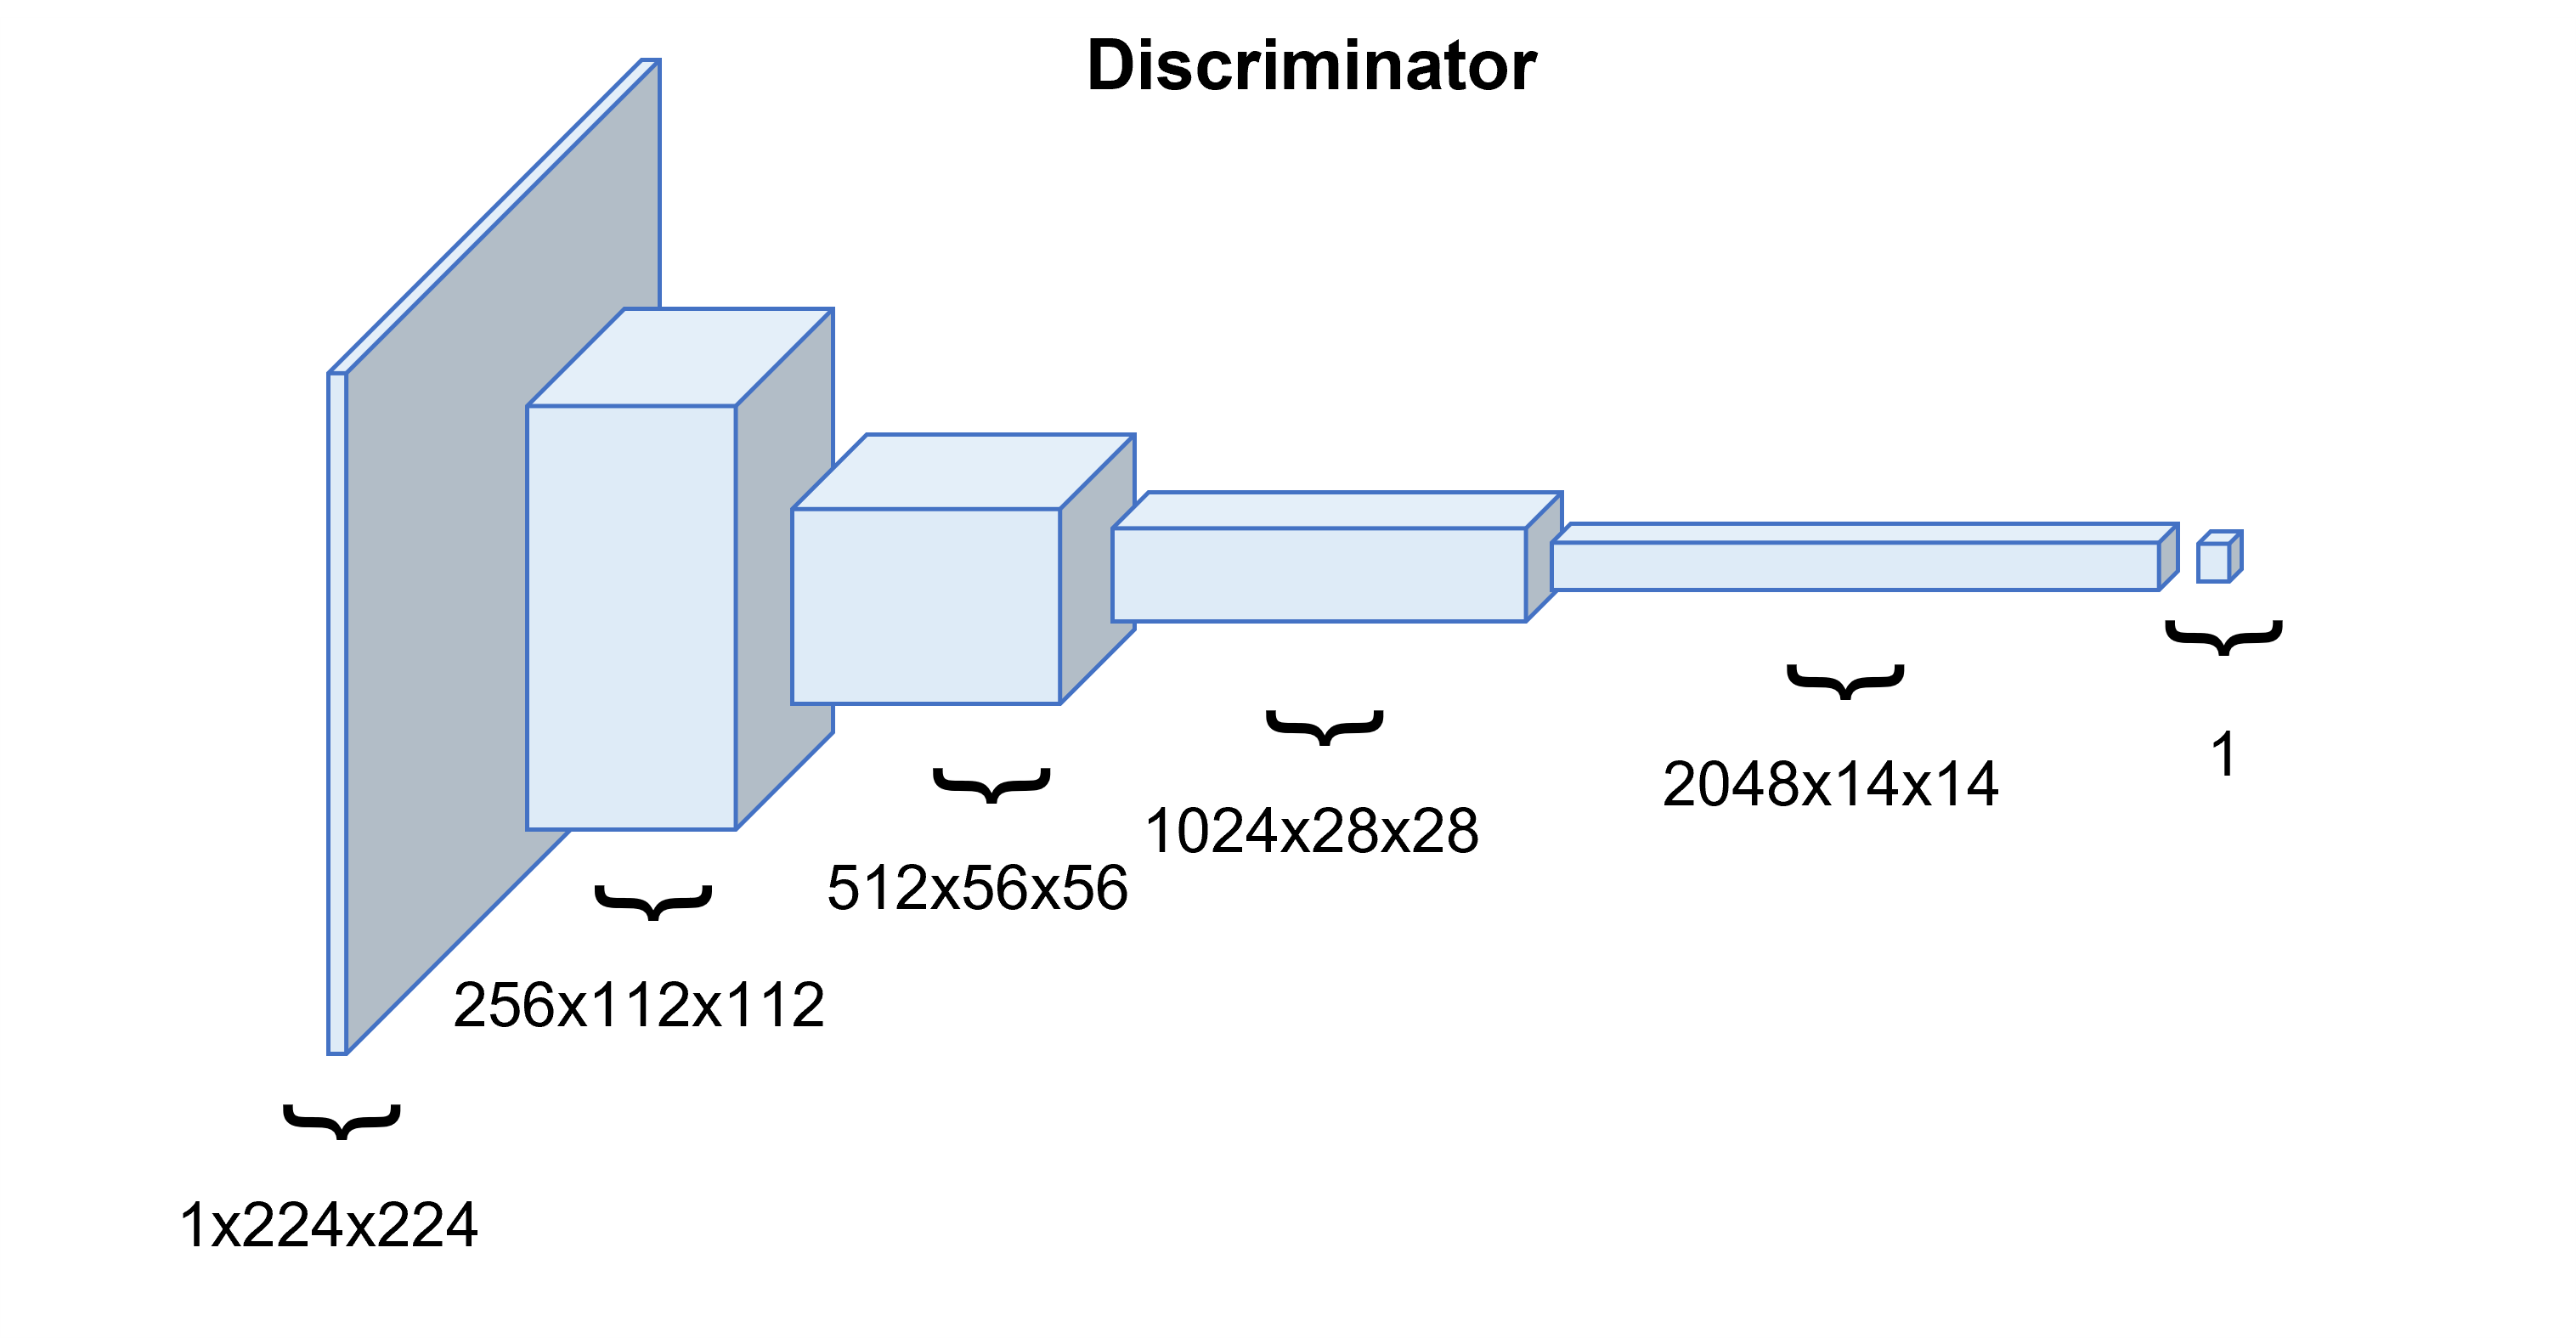

In [ ]:
# netG와 netD에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [29]:
# 모델 구성 부분
# 앞서 구성한 generator와 discriminator를 생성하고 초기화 합니다
netG = UNet(nc).to(device)
netD = Discriminator(nc).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(2048, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [30]:
# BCELoss 함수의 인스턴스를 생성합니다
criterion_BCE = nn.BCELoss()
criterion_MSE = nn.MSELoss()
# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=beta)
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=beta)

In [32]:
# 모델 학습 부분
G_losses = []                                                                     # Loss를 저장할 변수를 선언합니다
D_losses = []
val_G_losses = []
val_D_losses = []
best_loss = 1e5                                                                   # best loss 저장을 위한 변수

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(1,num_epochs+1):
    # 한 에폭 내 train 과 valid 페이즈를 나누어 
    # train 페이즈에만 파라미터 업데이트 하도록 설정합니다
    tmp_val_G_loss = 0                                                            # 한 epoch에서 저장할 임시 loss를 위한 변수
    tmp_val_D_loss = 0
    tmp_train_G_loss = 0
    tmp_train_D_loss = 0
    for phase in ['train','valid']:
        if phase=='train':
            netD.train()
            netG.train()
        else:
            netD.eval()
            netG.eval()
        for i, data in enumerate(dataloaders[phase],start=1):
            ############################
            # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
            ###########################
            ## 진짜 데이터들로 학습을 합니다
            gt = data[1]
            optimizerD.zero_grad()
            # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
            gt = gt.to(device)
            b_size = gt.size(0)
            label = torch.full((b_size,), real_label,                             # label = [1,1,1,....,1]
                               dtype=torch.float, device=device) 
            # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
            output = netD(gt).view(-1)
            # 손실값을 구합니다
            errD_real = criterion_BCE(output, label)
            # 역전파의 과정에서 변화도를 계산합니다
            if phase == 'train':
                errD_real.backward()
                
            D_x = output.mean().item()
           
            ## 가짜 데이터들로 학습을 합니다
            # 생성자에 사용할 노이즈 이미지를 불러옵니다.
            noise = data[0]
            noise = noise.to(device)
            # G를 이용해 노이즈가 제거된 이미지를 생성합니다
            fake = netG(noise)
            label.fill_(fake_label)                                               # label = [0,0,0,....,0]
            # D를 이용해 데이터의 진위를 판별합니다
            output = netD(fake.detach()).view(-1)
            # D의 손실값을 계산합니다
            errD_fake = criterion_BCE(output, label)
            # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
            
            D_G_z1 = output.mean().item()
            # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
            # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
            errD = errD_real + errD_fake
            # D를 업데이트 합니다
            if phase == 'train':
                errD_fake.backward()
                optimizerD.step()
    
            ############################
            # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
            ###########################
            optimizerG.zero_grad()
            label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
            # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다
            # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값과 다른 값이 나오게 됩니다
            output = netD(fake).view(-1)
            # G의 손실값을 구합니다
            MSE_loss = criterion_MSE(fake, gt)
            errG =   torch.sqrt(MSE_loss)
            # G의 변화도를 계산합니다
            D_G_z2 = output.mean().item()
            # G를 업데이트 하고 현재 epoch의 loss를 저장합니다
            if phase == 'train':
                errG.backward()
                optimizerG.step()
                tmp_train_G_loss += errG.item()
                tmp_train_D_loss += errD.item()
            else:
                tmp_val_G_loss += errG.item()
                tmp_val_D_loss += errD.item()
            # 훈련 상태를 출력합니다
            if phase=='train':
                print('\rtrain: [%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloaders['train']),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2),end='')
            else:
                print('\rvalid: [%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloaders['valid']),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2),end='')
                
        # epoch의 평균 loss를 저장합니다
        # valid phase인 경우 기존 best loss보다 현재 loss가 낮다면 현재 weight를 저장합니다
        if phase == 'train':
          G_losses.append(tmp_train_G_loss/len(dataloaders['train']))
          D_losses.append(tmp_train_D_loss/len(dataloaders['train']))
        else:
          val_G_losses.append(tmp_val_G_loss/len(dataloaders['valid']))
          val_D_losses.append(tmp_val_D_loss/len(dataloaders['valid']))
          if val_G_losses[-1]<best_loss:
            best_loss = val_G_losses[-1]
            print("\nsaving best model with %.4f loss"%(best_loss),end='')
            best_modelG_wts = copy.deepcopy(netG.state_dict())
            best_modelD_wts = copy.deepcopy(netD.state_dict())
      
        print()

Starting Training Loop...
train: [1/20][25/25]	Loss_D: 1.6333	Loss_G: 0.3074	D(x): 0.4826	D(G(z)): 0.0610 / 0.0034
valid: [1/20][4/4]	Loss_D: 17.1385	Loss_G: 0.3163	D(x): 0.0000	D(G(z)): 0.2271 / 0.2271
saving best model with 0.3007 loss
train: [2/20][25/25]	Loss_D: 2.8972	Loss_G: 0.0798	D(x): 0.9143	D(G(z)): 0.8504 / 0.9080
valid: [2/20][4/4]	Loss_D: 0.3119	Loss_G: 0.4832	D(x): 0.8644	D(G(z)): 0.1495 / 0.1495
train: [3/20][25/25]	Loss_D: 1.3807	Loss_G: 0.0557	D(x): 0.5589	D(G(z)): 0.5290 / 0.6921
valid: [3/20][4/4]	Loss_D: 1.8621	Loss_G: 0.1717	D(x): 0.4811	D(G(z)): 0.6146 / 0.6146
saving best model with 0.1766 loss
train: [4/20][25/25]	Loss_D: 1.5787	Loss_G: 0.0538	D(x): 0.3028	D(G(z)): 0.3117 / 0.4072
valid: [4/20][4/4]	Loss_D: 1.4541	Loss_G: 0.0567	D(x): 0.4285	D(G(z)): 0.4415 / 0.4415
saving best model with 0.0584 loss
train: [5/20][25/25]	Loss_D: 1.2750	Loss_G: 0.0653	D(x): 0.4864	D(G(z)): 0.4161 / 0.4667
valid: [5/20][4/4]	Loss_D: 2.3399	Loss_G: 0.0834	D(x): 0.7149	D(G(z)): 0.83

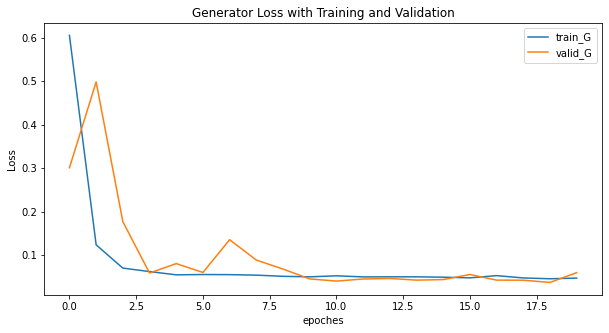

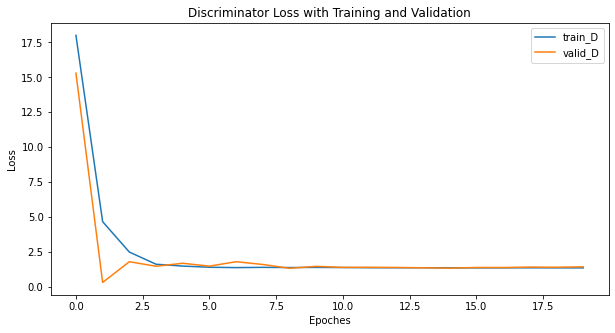

In [33]:
# Generator와 discriminator loss를 출력합니다
plt.figure(figsize=(10,5))
plt.title("Generator Loss with Training and Validation")
plt.plot(G_losses,label="train_G")
plt.plot(val_G_losses,label="valid_G")
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss with Training and Validation")
plt.plot(D_losses,label="train_D")
plt.plot(val_D_losses,label="valid_D")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
# 저장한 best weight를 불러옵니다
netG.load_state_dict(best_modelG_wts)
netD.load_state_dict(best_modelD_wts)

<All keys matched successfully>

In [35]:
# test셋에서 검증합니다
netG.eval()
tb = iter(dataloaders['test'])

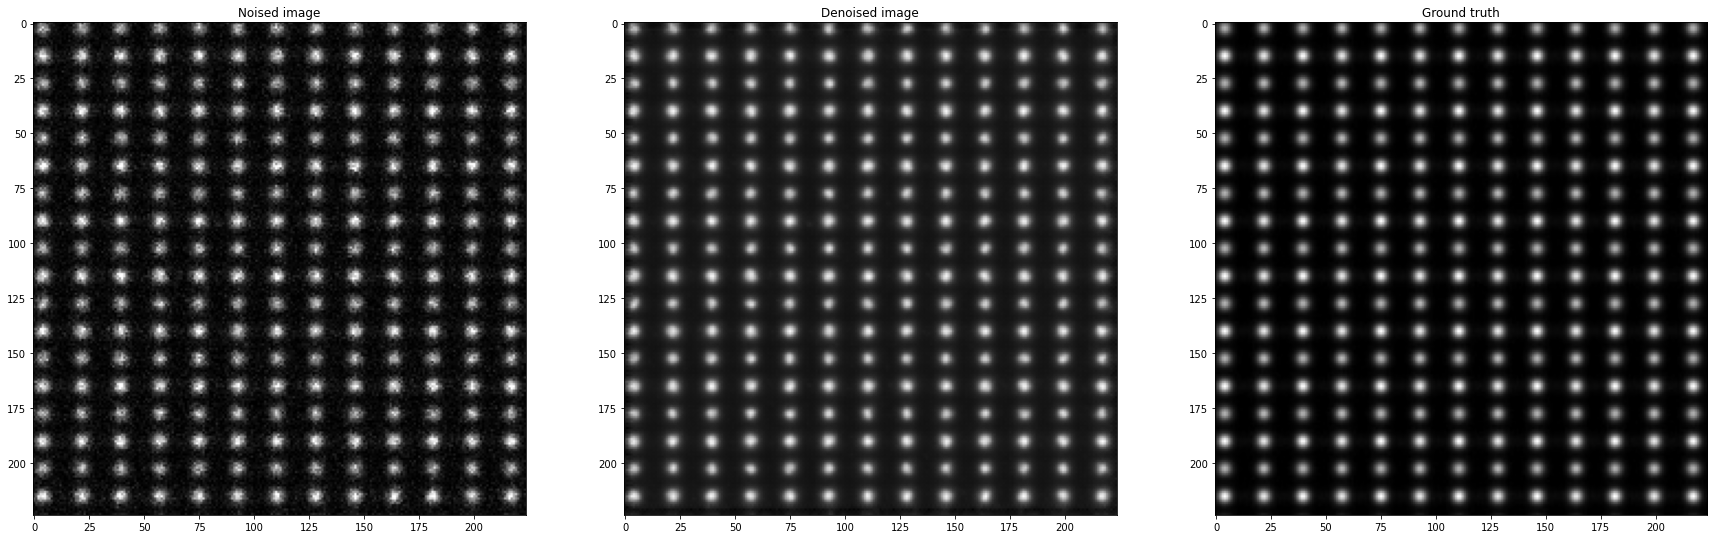

In [36]:
# test셋에서 데이터를 불러옵니다
test_batch = next(tb)
t_noise = test_batch[0].to(device)
t_img = test_batch[0].cpu().detach().numpy()[0].transpose((1,2,0))
t_gt = test_batch[1].cpu().detach().numpy()[0].transpose((1,2,0))
# 학습된 모델로 noise 이미지를 denoising 합니다
test_result = netG(t_noise)
test_result = test_result.cpu().detach().numpy()[0].transpose((1,2,0))
# -1 ~ 1 까지 normalize 된 이미지를 0 ~ 1로 다시 normalize 합니다
test_result = (test_result+1)*0.5
t_gt = (t_gt+1)*0.5
t_img = (t_img+1)*0.5
# 결과를 출력합니다
fig, ax = plt.subplots(1,3,figsize=(30,30))
ax[0].set_title('Noised image')
ax[0].imshow(t_img[:,:,0],cmap='gray')
ax[1].set_title('Denoised image')
ax[1].imshow(test_result[:,:,0],cmap='gray')
ax[2].set_title('Ground truth')
ax[2].imshow(t_gt[:,:,0],cmap='gray')
plt.show()

In [37]:
# psnr을 계산하기 위한 함수
def calc_psnr(truth,compare,pixel_max=255.0):
    mse = np.mean((truth-compare)**2)
    if mse == 0:
        return 100
    return 20*math.log10(pixel_max/math.sqrt(mse))


In [38]:
# 전체 test셋에 대해 psnr과 mse를 계산합니다
tb = iter(dataloaders['test'])
total_mse = []
total_psnr = []
for test_batch in tb:
    t_noise = test_batch[0].cuda()
    t_img = test_batch[0].cpu().detach().numpy()[0].transpose((1,2,0))
    t_gt = test_batch[1].cpu().detach().numpy()[0].transpose((1,2,0))
    test_result = netG(t_noise).cpu().detach().numpy()[0]
    test_result = test_result.transpose((1,2,0))
    test_result = (test_result+1)*127.5
    t_gt = (t_gt+1)*127.5
    t_img = (t_img+1)*127.5
    mse = mean_squared_error(t_gt[:,:,0]/255,test_result[:,:,0]/255)
    p = calc_psnr(t_gt[:,:,0],test_result[:,:,0])
    total_mse.append(mse)
    total_psnr.append(p)
# 평균 mse와 pnsr을 계산합니다
print("평균 MSE: %.6f" %(np.mean(total_mse)))
print("평균 PSNR: %.6f"  %(np.mean(total_psnr)))


평균 MSE: 0.000566
평균 PSNR: 32.548722
